In [51]:
import jax
from jax.numpy.fft import fft, ifft
import jax.numpy as jnp
import matplotlib.pyplot as plt  
from jax import grad, vmap


import sys
root = '/home/emastr/github/phd/projects/vahid_project/'
sys.path.append('..')
sys.path.append(f'{root}src/')
sys.path.append(f'{root}util/')
sys.path.append(f'{root}data/')
from multiprocessing import Pool
from matplotlib.colors import LogNorm
from alignment_vmap import *
from alignment_vmap import em_method, fix_point_iter, align_average, autocorr_fft, hessian_declarative, hessian_declarative_real
from alignment_vmap import align_average_and_project, align, invariants_from_data, bispectrum_inversion


# Use finite difference hessian for stepping.

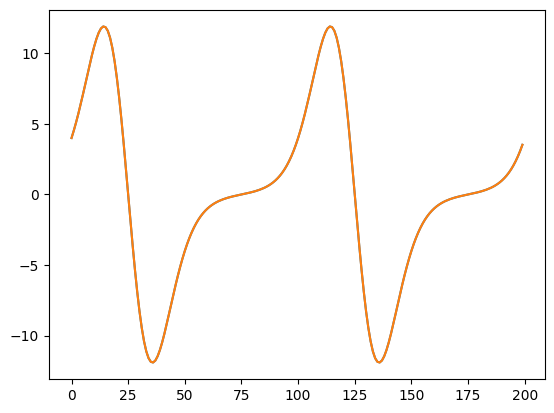

In [52]:
def get_samples(key, x, noise_std, N):
    L = len(x)
    shiftkey, noisekey = jax.random.split(key, 2)
    shift = jax.random.randint(shiftkey, (N,), 0, L)
    noise = jax.random.normal(noisekey, (N, L)) * noise_std
    y = vmap(lambda s, z: jnp.roll(x + z, s), in_axes=(0, 0))(shift, noise)
    return y, noise, shift



t = jnp.linspace(0, 2*jnp.pi, 201)[:-1]
f = lambda t: jnp.exp(2*jnp.sin(2*t))
x = f(t)
dx = vmap(grad(f))(t)

ks = jnp.fft.fftfreq(len(t), 2*jnp.pi/len(t))


xfft = fft(x)
dxfft = 1j * ks * xfft * 2*jnp.pi

#plt.plot(ifft(xfft).real)
plt.plot(dx)
plt.plot(ifft(dxfft).real)
#plt.plot(x)


In [53]:
outer = lambda x, y: jnp.einsum('i,j->ij', x.conj(), y)
inner = lambda x, y: jnp.einsum('i,i->', x.conj(), y)
diff = lambda x: (x - jnp.roll(x, len(x)//10))/float(len(x)//10)*float(len(x))

t = jnp.linspace(0, 2*jnp.pi, 41)[:-1]
#f = lambda t: 1/(1 + jnp.exp(-jnp.sin(t)/0.05)) #jnp.exp(2*jnp.sin(2*t))
#f = lambda t: jnp.where(t < jnp.pi, 0., 1.)
f = lambda t: jnp.exp(2*jnp.sin(3*t))
#f = lambda t: jnp.exp(2*jnp.sin(2*t))
stdev = 1.
N = 10000
x = f(t)
y, noise, shift = get_samples(random.PRNGKey(4), x, stdev, N)

#x = x + 0.1 * random.normal(random.PRNGKey(0), x.shape) * 1. #+ x
x = -x
xfft = fft(x)
yfft = fft(y, axis=1)
I = jnp.eye(len(x))

def mean_compute(func, x, Mmax):
    M = x.shape[0]
    if M < Mmax:
        return jnp.mean(vmap(func)(x), axis=0)
    else:
        result = func(x[0])
        for m in range(M):
            result += func(x[m])
        return jnp.mean(func(*args), axis=0)
    

def hes_fourier(xfft, yfft, kmax):
    ks = jnp.fft.fftfreq(len(t), 2*jnp.pi/len(t)) * 1j * 2 * jnp.pi
    yfft_roll = align_fft(xfft, yfft)
    # truncate by setting ks to zero for large frequencies
    ks = ks * (jnp.abs(ks) < kmax)
    dyfft = ks * yfft
    dyfft_roll = ks * yfft_roll
    dxfft = ks * xfft
    Afft = I  - outer(dyfft_roll, dyfft_roll)/inner(dyfft_roll, dxfft)
    return  ifft(ifft(Afft.conj(), axis=0).conj(), axis=1) * len(x)#,  Afft


def hes_fourier_shift(xfft, yfft, kmax, shift):
    ks = jnp.fft.fftfreq(len(t), 2*jnp.pi/len(t)) * 1j * 2 * jnp.pi
    #yfft_roll = align_fft(xfft, yfft)
    yfft_roll = roll_fft(yfft, -shift)
    # truncate by setting ks to zero for large frequencies
    ks = ks * (jnp.abs(ks) < kmax)
    dyfft_roll = ks * yfft_roll
    dxfft = ks * xfft
    Afft = I  - outer(dyfft_roll, dyfft_roll)/inner(dyfft_roll, dxfft)
    return  ifft(ifft(Afft.conj(), axis=0).conj(), axis=1) * len(x)#,  Afft

def hes_diff(x, y, kmax):
    pass

def hes_autograd(x, y, shift):
    ks = jnp.fft.fftfreq(len(t), 2*jnp.pi/len(t)) * 1j * 2 * jnp.pi
    xfft = fft(x)
    dxfft = ks * xfft
    dx = ifft(dxfft).real
        
    y = vmap(f)(t)
    yfft = fft(y)
    dy = vmap(grad(f))(t) #diff(x)
    shift = find_shift(xfft, yfft)
    dy_shift = jnp.roll(dy, shift)
    return I - outer(dy_shift, dy_shift)/inner(dy_shift, dx)# * len(x)

@jit
def loss(x):
    #return jnp.sum(x*jnp.roll(x, 1))
    return loss_fft(fft(x), yfft)

def hes_finite_diff(x, i, j, h=1e-1):
    Aij = 0
    for p in [-1, 1]:
        for q in [-1, 1]:
            Aij += q*p*loss(x + (p * I[i, :] + q * I[j, :])*h/2) / h**2
        #print(i, j)
    return Aij

def hes_finite_diff_full(x, h= 1e-1):
    i_vec = jnp.arange(len(x))
    i_mat, j_mat = jnp.meshgrid(i_vec, i_vec)
    return jit(vmap(vmap(hes_finite_diff, (None, 0, 0, None)), (None, 0, 0, None)))(x, i_mat, j_mat, h)

ymean, yauto_fft, _ = invariants_from_data(y, stdev)
xfft = fix_point_iter(fft(x), yfft, yauto_fft, ymean, tol=1e-6, alpha=0.9, maxiter=1000)
x = ifft(xfft).real
        
ifftAfft = jnp.mean(vmap(hes_fourier, (None, 0, None))(xfft, yfft, 1e5), axis=0).real
#ifftAfft_shift = jnp.mean(vmap(hes_fourier_shift, (None, 0, None, 0))(xfft, yfft, 1e5, shift), axis=0).real
ifftAfft_shift = jnp.mean(vmap(hessian_declarative_real, (None, 0, 0))(x, yfft, y), axis=0).real
#ifftAfft_shift = ifft(ifft(Afft_shift.conj(), axis=0).conj(), axis=1).real * len(x)

A = jnp.mean(vmap(hes_autograd, (None, 0, 0))(x, y, shift), axis=0)
Afd = hes_finite_diff_full(x)


: 

Text(0.5, 1.0, 'Diagonal of Hessian')

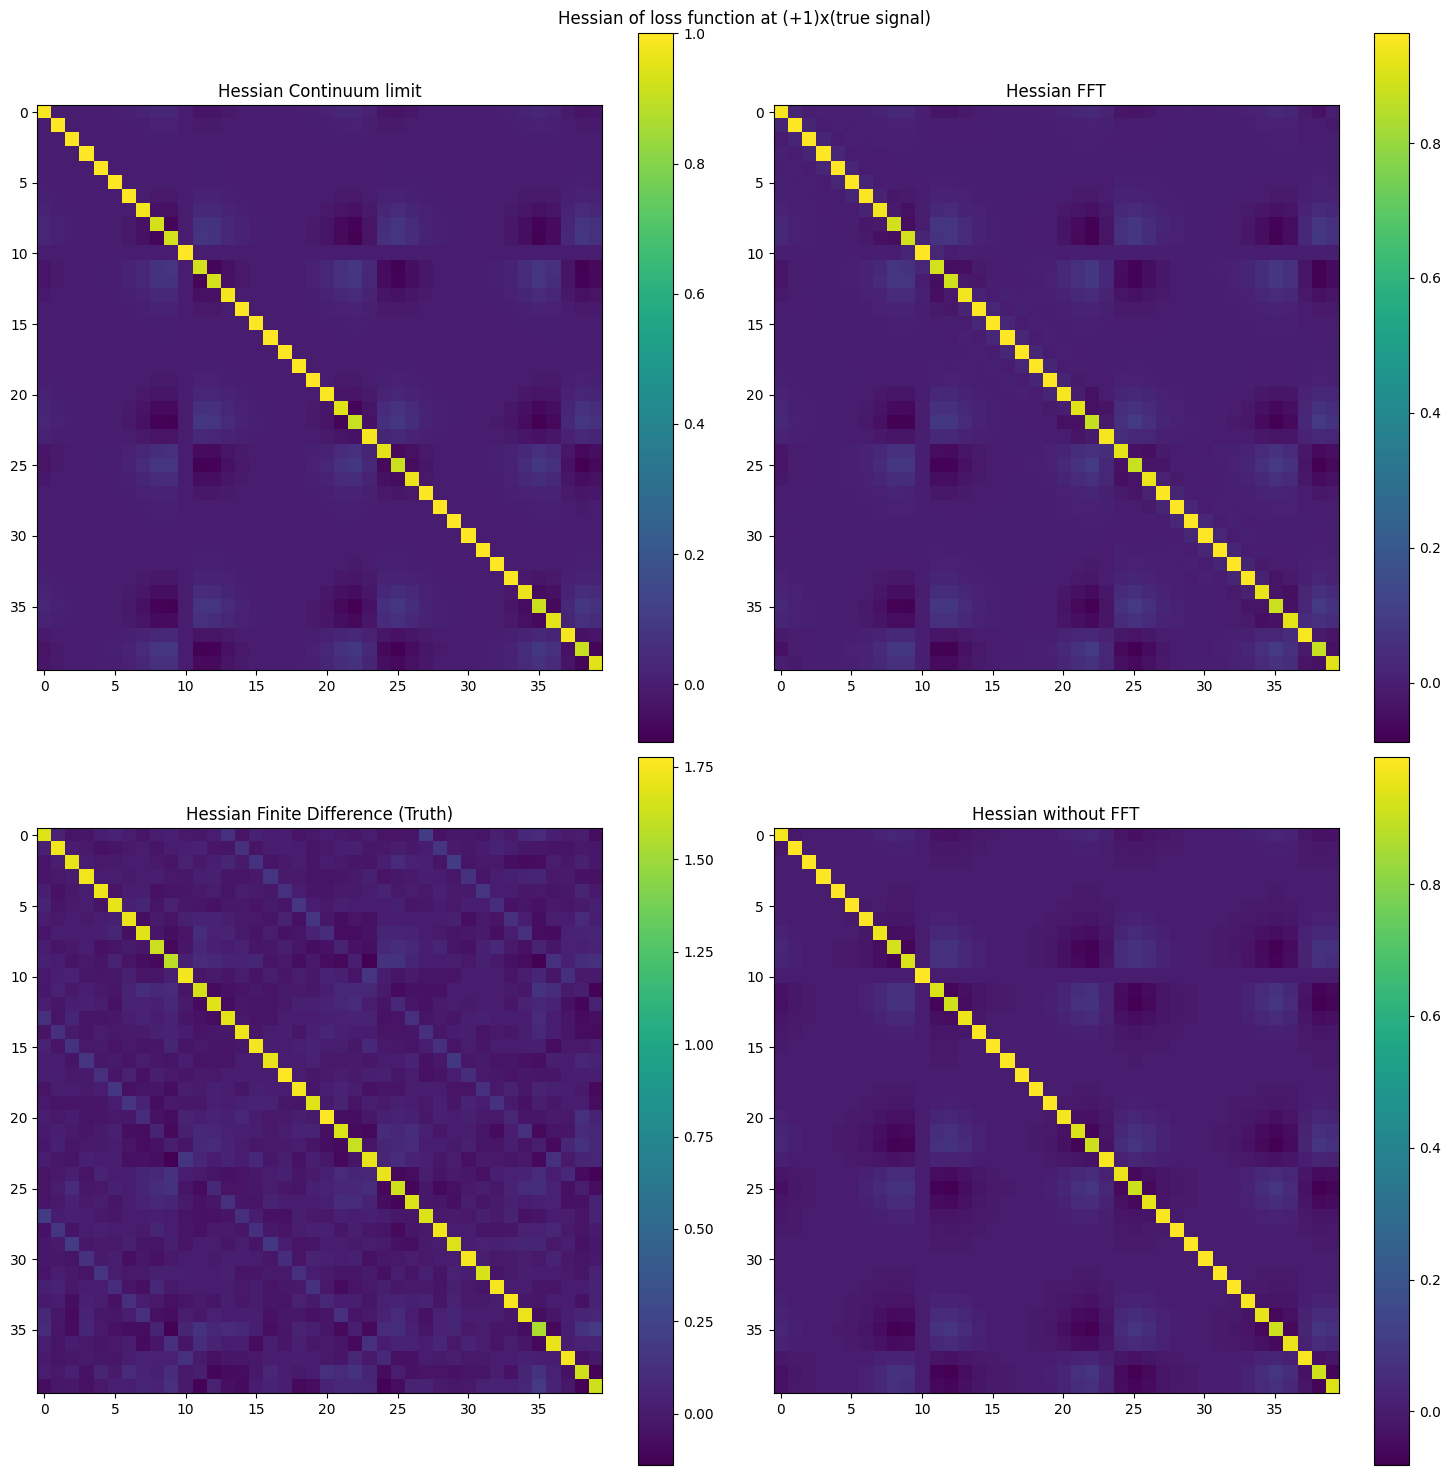

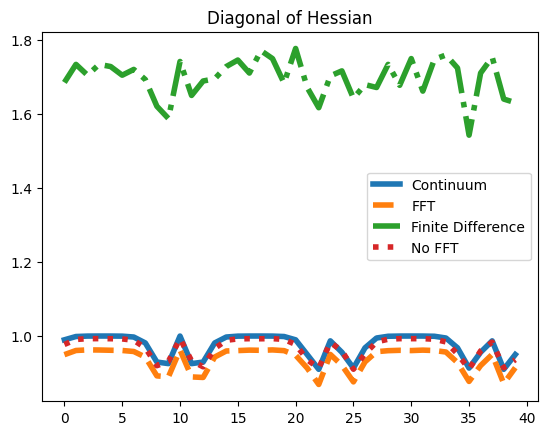

In [ ]:

plt.figure(figsize=(15,15))
plt.subplot(221)
plt.title("Hessian Continuum limit")
plt.imshow(A)
plt.colorbar()

plt.subplot(222)
plt.title("Hessian FFT")
plt.imshow(ifftAfft)
plt.colorbar()

plt.subplot(223)
plt.title("Hessian Finite Difference (Truth)")
#plt.imshow(Afd-jnp.diag(jnp.diag(Afd)))
plt.imshow(Afd)
plt.colorbar()

plt.subplot(224)
plt.title("Hessian without FFT")
plt.imshow(ifftAfft_shift)
plt.colorbar()

plt.suptitle("Hessian of loss function at (+1)x(true signal)")
plt.tight_layout()

plt.figure()
mats = [A, ifftAfft, Afd, ifftAfft_shift]
names = ['Continuum', 'FFT', 'Finite Difference', 'No FFT']
styles= ['-', '--', '-.', ':']
for Ai, name, style in zip(mats, names, styles):
    plt.plot(jnp.diag(Ai), style, label=name, linewidth=4)
plt.legend()
plt.title("Diagonal of Hessian")

Let $y$ be the sample, and suppose the shift is $\sigma(x)$. Then, the "hessian" $H_x\colon C[0,2\pi]\times C[0,2\pi] \to \mathbb{R}$ is a bilinear form given by:

$$
    H_x(u, v) = (u, v) - \frac{(u, \sigma_x y')(\sigma_x y', v)}{(\sigma_x y', x')}
$$

where $y'$ and $x'$ are the derivatives of the signals, and $(., .)$ is the standard $L^2$ inner product.

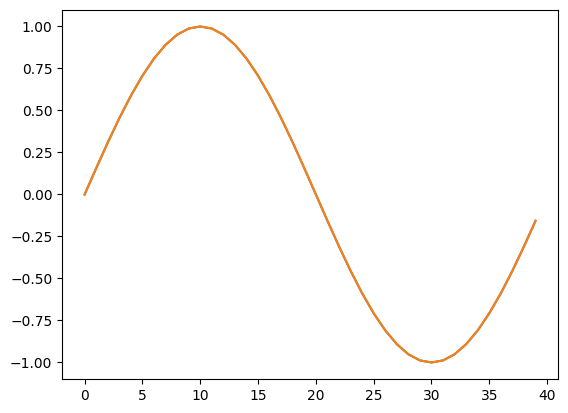

In [ ]:
x = jnp.sin(t)
y = jnp.roll(x, 10)

x2 = ifft(roll_fft(fft(y), -10)).real

plt.plot(x)
plt.plot(x2)
